<a href="https://colab.research.google.com/github/casangi/sirius/blob/main/docs/simple_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Simulation

In [1]:
import os
try:
    import sirius 
    print('SiRIUS version',sirius.__version__,'already installed.')
except:
    print('Installing SiRIUS')
    os.system("pip install sirius")
    import sirius 
    print('SiRIUS version',sirius.__version__,' installed.')

SiRIUS version 0.0.20 already installed.


## Load Packages

In [2]:
import pkg_resources
import xarray as xr
import numpy as np
from astropy.coordinates import SkyCoord
xr.set_options(display_style="html")
import os
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
except:
    IN_COLAB = False
%matplotlib widget 

## Load Telescope Layout 

In [3]:
########## Get telescope layout ##########
tel_dir = pkg_resources.resource_filename('sirius_data', 'telescope_layout/data/vla.d.tel.zarr')
tel_xds = xr.open_zarr(tel_dir,consolidated=False)
n_ant = tel_xds.dims['ant_name']
#tel_xds.attrs['telescope_name'] = 'EVLA'
tel_xds

<xarray.Dataset>
Dimensions:        (ant_name: 27, pos_coord: 3)
Coordinates:
  * ant_name       (ant_name) <U3 'W01' 'W02' 'W03' 'W04' ... 'N07' 'N08' 'N09'
  * pos_coord      (pos_coord) int64 0 1 2
Data variables:
    ANT_POS        (ant_name, pos_coord) float64 dask.array<chunksize=(27, 3), meta=np.ndarray>
    DISH_DIAMETER  (ant_name) float64 dask.array<chunksize=(27,), meta=np.ndarray>
Attributes:
    site_pos:        [{'m0': {'unit': 'm', 'value': -1601185.3650000016}, 'm1...
    telescope_name:  VLA

## Create Time and Freq Xarrays
The chunking of time_xda and chan_xda determines the number of branches in the DAG (maximum parallelism = n_time_chunks x n_chan_chunks).

In [4]:
from sirius.dio import make_time_xda
#time_xda = make_time_xda(time_start='2019-10-03T19:00:00.000',time_delta=3600,n_samples=10,n_chunks=4)
time_xda = make_time_xda(time_start='2019-10-03T19:00:00.000',time_delta=3600,n_samples=10,n_chunks=1)
time_xda

Number of chunks  1


<xarray.DataArray 'array-284441b7a6b803b0f7b6259088ebb97b' (time: 10)>
dask.array<array, shape=(10,), dtype=<U23, chunksize=(10,), chunktype=numpy.ndarray>
Dimensions without coordinates: time
Attributes:
    time_delta:  3600.0

In [5]:
from sirius.dio import make_chan_xda
spw_name = 'SBand'
#chan_xda = make_chan_xda(freq_start = 3*10**9, freq_delta = 0.4*10**9, freq_resolution=0.01*10**9, n_channels=3, n_chunks=3)
chan_xda = make_chan_xda(freq_start = 3*10**9, freq_delta = 0.4*10**9, freq_resolution=0.01*10**9, n_channels=3, n_chunks=1)
chan_xda

Number of chunks  1


<xarray.DataArray 'array-a1626d6bba95e075af6eee1f606620cd' (chan: 3)>
dask.array<array, shape=(3,), dtype=float64, chunksize=(3,), chunktype=numpy.ndarray>
Dimensions without coordinates: chan
Attributes:
    freq_resolution:  10000000.0
    spw_name:         sband
    freq_delta:       400000000.0

## Beam Models

In [6]:
from sirius_data.dish_models_1d.airy_disk import vla #Get airy disk parameters for VLA dish (obtained from https://open-bitbucket.nrao.edu/projects/CASA/repos/casa6/browse/casatools/src/code/synthesis/TransformMachines/PBMath.cc)
airy_disk_parms = vla
print(airy_disk_parms)

beam_models = [airy_disk_parms]
beam_model_map = np.zeros(n_ant,dtype=int) #Maps the antenna index to a model in beam_models. 
beam_parms = {} #Use default beam parms.

#If no beam should be used:
#none_model = {'pb_func':'none','dish_diameter':0.0,'blockage_diameter':0.0}

#If Zernike Polynomial should be used:
zpc_dir = pkg_resources.resource_filename('sirius_data', 'zernike_dish_models/data/EVLA_avg_zcoeffs_SBand_lookup.zpc.zarr')
zpc_xds = xr.open_zarr(zpc_dir,consolidated=False)

#beam_models = [zpc_xds]
zpc_xds

{'pb_func': 'casa_airy', 'dish_diam': 24.5, 'blockage_diam': 0.0, 'max_rad_1GHz': 0.014946999714079439}


<xarray.Dataset>
Dimensions:    (pol: 4, chan: 16, coef_indx: 66)
Coordinates:
  * chan       (chan) float64 2.052e+09 2.18e+09 ... 3.844e+09 3.972e+09
  * coef_indx  (coef_indx) int64 0 1 2 3 4 5 6 7 8 ... 58 59 60 61 62 63 64 65
  * pol        (pol) int64 5 6 7 8
Data variables:
    ETA        (pol, chan, coef_indx) float64 dask.array<chunksize=(4, 16, 66), meta=np.ndarray>
    ZC         (pol, chan, coef_indx) complex128 dask.array<chunksize=(4, 16, 66), meta=np.ndarray>
Attributes:
    conversion_date:  2022-01-03
    dish_diam:        25
    max_rad_1GHz:     0.014946999714079439
    telescope_name:   EVLA
    zpc_file_name:    EVLA_avg_zcoeffs_SBand_lookup.csv

## Polarization Setup

In [7]:
#https://github.com/casacore/casacore/blob/dbf28794ef446bbf4e6150653dbe404379a3c429/measures/Measures/Stokes.h
# ['RR','RL','LR','LL'] => [5,6,7,8], ['XX','XY','YX','YY'] => [9,10,11,12]
pol = [5,8] 

## UVW Parameters

In [8]:
# If using uvw_parms['calc_method'] = 'casa' .casarc must have directory of casadata. 
import pkg_resources
casa_data_dir = pkg_resources.resource_filename('casadata', '__data__')
rc_file = open(os.path.expanduser("~/.casarc"), "a+")  # append mode
rc_file.write("\n measures.directory: " + casa_data_dir)
rc_file.close()

uvw_parms = {}
uvw_parms['calc_method'] = 'casa' #'astropy' or 'casa'
uvw_parms['auto_corr'] = False

## Sources
### point_source_ra_dec:  [n_time, n_point_sources, 2] (singleton: n_time)

In [9]:
point_source_skycoord = SkyCoord(ra='19h59m50.51793355s',dec='+40d48m11.3694551s',frame='fk5') 
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])[None,None,:]

### point_source_flux: [n_point_sources, n_time, n_chan, n_pol] (singleton: n_time, n_chan)
All 4 instramental pol values must be given even if only RR and LL are requested. 

In [10]:
point_source_flux = np.array([1.0, 0, 0, 1.0])[None,None,None,:] 

## Telescope Setup
### phase_center:  [n_time, 2] (singleton: n_time)
### phase_center_names: [n_time] (singleton: n_time)

In [11]:
phase_center = SkyCoord(ra='19h59m28.5s',dec='+40d44m01.5s',frame='fk5')
phase_center_ra_dec = np.array([phase_center.ra.rad,phase_center.dec.rad])[None,:]
phase_center_names = np.array(['field1'])

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:


from sirius._sirius_utils._coord_transforms import _calc_rotation_mats, _directional_cosine,  _sin_project

print(phase_center_ra_dec[0,:],point_source_ra_dec[0,:,:])
lm_sin = _sin_project(phase_center_ra_dec[0,:],point_source_ra_dec[0,:,:])[0,:]
print('%.15f' % lm_sin[0],'%.15f' % lm_sin[1])


[5.23369701 0.71093805] [[5.2352982  0.71214946]]
0.001212034202758 0.001212034202764


### pointing_ra_dec:[n_time, n_ant, 2]                   (singleton: n_time, n_ant) or None

In [14]:
pointing_ra_dec = None #No pointing offsets

## Noise

In [15]:
noise_parms = None
#noise_parms ={}

## Run Simulation
Write to disk as a measuremnt set and create DAGs.

In [16]:
from sirius import simulation
save_parms = {'ms_name':'simple_sim3.ms','write_to_ms':True,'DAG_name_vis_uvw_gen':'DAG_vis_uvw_gen.png','DAG_name_write':'DAG_write.png'}
ms_xds = simulation(point_source_flux, 
                     point_source_ra_dec, 
                     pointing_ra_dec, 
                     phase_center_ra_dec, 
                     phase_center_names, 
                     beam_parms,beam_models,
                     beam_model_map,uvw_parms, 
                     tel_xds, time_xda, chan_xda, pol, noise_parms, save_parms) 
ms_xds

Setting default fov_scaling  to  15
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]
Meta data creation  4.104203701019287
reshape time  0.0018122196197509766
*** Dask compute time 9.645293712615967
compute and save time  9.645580291748047


[<xarray.Dataset>
 Dimensions:         (row: 3510, chan: 3, corr: 2, uvw: 3)
 Coordinates:
     ROWID           (row) int32 dask.array<chunksize=(3510,), meta=np.ndarray>
 Dimensions without coordinates: row, chan, corr, uvw
 Data variables: (12/21)
     DATA            (row, chan, corr) complex64 dask.array<chunksize=(3510, 3, 2), meta=np.ndarray>
     EXPOSURE        (row) float64 dask.array<chunksize=(3510,), meta=np.ndarray>
     SCAN_NUMBER     (row) int32 dask.array<chunksize=(3510,), meta=np.ndarray>
     SIGMA           (row, corr) float32 dask.array<chunksize=(3510, 2), meta=np.ndarray>
     ANTENNA1        (row) int32 dask.array<chunksize=(3510,), meta=np.ndarray>
     ARRAY_ID        (row) int32 dask.array<chunksize=(3510,), meta=np.ndarray>
     ...              ...
     UVW             (row, uvw) float64 dask.array<chunksize=(3510, 3), meta=np.ndarray>
     WEIGHT          (row, corr) float32 dask.array<chunksize=(3510, 2), meta=np.ndarray>
     TIME            (row) float

## Image Simulated Dataset

In [17]:
from casatasks import tclean
os.system('rm -rf simple.*')
tclean(vis=save_parms['ms_name'],imagename='simple',imsize=[400,400],cell=[5.0,5.0],specmode='cube',niter=1000,pblimit=0.1,pbmask=0.1,gridder='standard',stokes='RR')

{}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.6360993
Peak Intensity (chan0) : 0.6360901
PB at location of Intensity peak (chan0) : 0.6360983
max pixel location  (array([150]), array([250]), array([0]), array([0]))
Residual RMS : 0.0001055


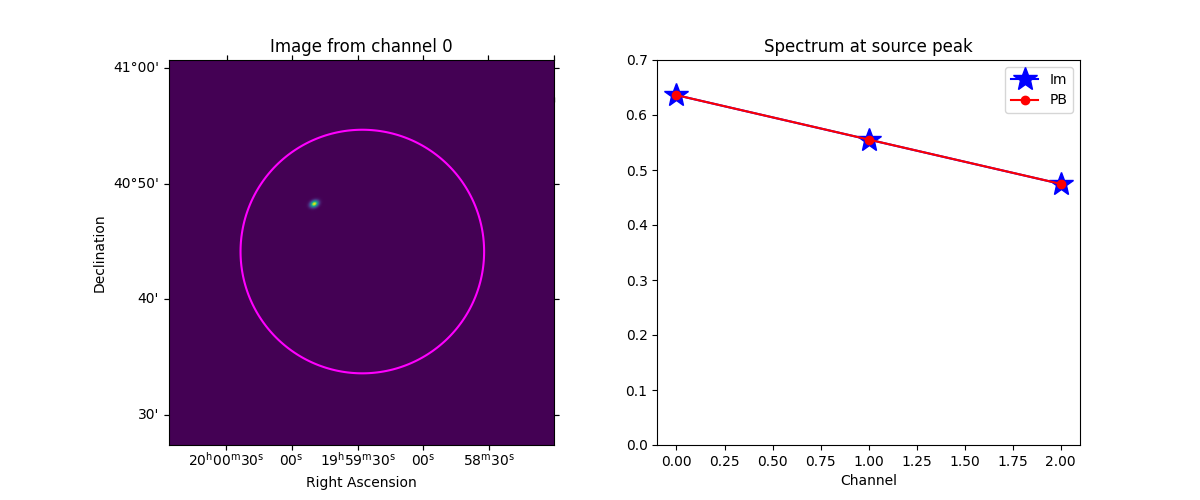

(0.636090099811554, 0.00010554419767426623)

In [18]:
%load_ext autoreload
%autoreload 2

chan=0

from sirius.display_tools import display_image
print(np.abs(ms_xds[0].DATA[0,chan,0].values))
display_image(imname='simple.image',pbname='simple.pb',resname='simple.residual',ylim=[0.0,0.7],chan=chan)